In [1]:
# requires
# pip install git+https://github.com/Phylliida/MambaLens.git

from mamba_lens import HookedMamba # this will take a little while to import

model_path = "state-spaces/mamba-370m"
model = HookedMamba.from_pretrained(model_path, device='cuda')

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


In [2]:
# remember to do
# pip install -e .
# in the root directory of this repo
# also
# to install graphviz:
# sudo apt-get update
# sudo apt-get install graphviz xdg-utils

from acdc.data.ioi import ioi_data_generator, ABC_TEMPLATES, get_all_single_name_abc_patching_formats
from acdc.data.utils import generate_dataset

num_patching_pairs = 50
seed = 27
valid_seed = 28
constrain_to_answers = True
has_symmetric_patching = True

templates = ABC_TEMPLATES
patching_formats = list(get_all_single_name_abc_patching_formats())

data = generate_dataset(model=model,
                  data_generator=ioi_data_generator,
                  num_patching_pairs=num_patching_pairs,
                  seed=seed,
                  valid_seed=valid_seed,
                  constrain_to_answers=constrain_to_answers,
                  has_symmetric_patching=has_symmetric_patching, 
                  varying_data_lengths=True,
                  templates=templates,
                  patching_formats=patching_formats)

In [3]:
import torch
from acdc import get_pad_token

print("printing example data points:")
for b in range(10):
    pad_token = get_pad_token(model.tokenizer)
    # because there is padding if lengths vary, this only fetches the tokens that are part of the sequence
    toks = data.data[b][:data.last_token_position[b]+1]
    print(model.tokenizer.decode(toks))
    for ind, tok in enumerate(data.correct[b]):
        if tok != pad_token:
            print(f"  correct answer: {repr(model.tokenizer.decode([tok.item()]))}")
    for ind, tok in enumerate(data.incorrect[b]):
        if tok != pad_token:
            print(f"  incorrect answer: {repr(model.tokenizer.decode([tok.item()]))}")

from acdc import accuracy_metric
from acdc import ACDCEvalData
from acdc import get_pad_token
def logging_incorrect_metric(data: ACDCEvalData):
    pad_token = get_pad_token(model.tokenizer)
    for data_subset in [data.patched, data.corrupted]:
        batch, _ = data_subset.data.size()
        for b in range(batch):
            if not data_subset.top_is_correct[b].item():
                toks = data_subset.data[b][:data_subset.last_token_position[b]+1]
                print("failed on this data point:")
                print(model.tokenizer.decode(toks))
                print("correct prs:")
                for i, tok in enumerate(data_subset.correct[b]):
                    if tok.item() != pad_token:
                        print(data_subset.correct_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
                print("incorrect prs:")
                for i, tok in enumerate(data_subset.incorrect[b]):
                    if tok.item() != pad_token:
                        print(data_subset.incorrect_prs[b,i].item(), model.tokenizer.decode([tok.item()]))
    return data.patched.top_is_correct

top_is_correct = data.eval(model=model, batch_size=10, metric=logging_incorrect_metric)
accuracy = top_is_correct.sum().item()/top_is_correct.size()[0]
print(f"accuracy: {accuracy}")


printing example data points:
<|endoftext|>Friends Brian, Lily and Diana went to the house. Brian and Lily gave a apple to
  correct answer: ' Diana'
  incorrect answer: ' Brian'
  incorrect answer: ' Donovan'
  incorrect answer: ' Lily'
<|endoftext|>Friends Brian, Lily and Donovan went to the house. Brian and Lily gave a apple to
  correct answer: ' Donovan'
  incorrect answer: ' Brian'
  incorrect answer: ' Diana'
  incorrect answer: ' Lily'
<|endoftext|>When Catherine, Jordan and Owen arrived at the office, Catherine and Owen gave a apple to
  correct answer: ' Jordan'
  incorrect answer: ' Catherine'
  incorrect answer: ' Henry'
  incorrect answer: ' Owen'
<|endoftext|>When Catherine, Henry and Owen arrived at the office, Catherine and Owen gave a apple to
  correct answer: ' Henry'
  incorrect answer: ' Catherine'
  incorrect answer: ' Jordan'
  incorrect answer: ' Owen'
<|endoftext|>When Edwin, Miranda and Marco arrived at the office, Miranda and Marco gave a kiss to
  correct an

all nodes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '5', '6', '7', '8', '9', 'input', 'output']
patching 0 edges, keeping 0 edges, 1225 remain
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 2.651578664779663
[49] sized edge sets remaining
got scores tensor([1.6466e-07], device='cuda:0')
splitting 49 edges into two edge sets, as they have score 1.646648115638527e-07 which has diff 2.651578426361084 > 1e-05
patching 0 edges, keeping 0 edges, 1225 remain
baseline score 2.651578664779663
[24, 25] sized edge sets remaining
got scores tensor([2.6515e+00, 9.6757e-05], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.651517868041992 which has diff 6.079673767089844e-05 > 1e-05
splitting 25 edges into two edge sets, as they have score 9.675651

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7001, 2.6999, 2.6999, 2.7002, 2.6198, 2.6724, 2.7079, 0.4702, 2.6747,
        2.3683], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.6998884677886963 which has diff 0.0001621246337890625 > 1e-05
keeping edge edge  14 -> output (('blocks.14.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.699887752532959 which has diff 0.0001628398895263672 > 1e-05
keeping edge edge  35 -> output (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.619821786880493 which has diff 0.08022880554199219 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.672353982925415 which has diff 0.027696609497070312 > 1e-05
splitting 2 edges into two edge sets, as they have score 0.47024503350257874 which has diff 2.2298054695129395 

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7080, 2.7078, 2.6794, 2.7089, 0.5256, 2.6608, 2.7175, 2.6732, 2.6373,
        2.4477], device='cuda:0')
keeping edge edge  13 -> output (('blocks.13.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.707810640335083 which has diff 0.00014162063598632812 > 1e-05
keeping edge edge  36 -> output (('blocks.36.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.6793603897094727 which has diff 0.02859187126159668 > 1e-05
keeping edge edge  39 -> output (('blocks.39.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_resid_post', <function resid_patching_hook at 0x7fb524c0a680>))) with score 0.5256035327911377 which has diff 2.1823487281799316 > 1e-05
keeping edge edge  40 -> output (('blocks.40.hook_out_proj', <function storage_hook at 0

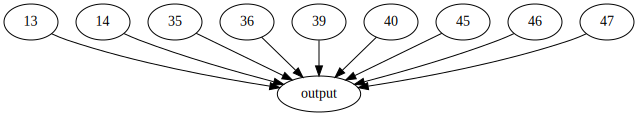

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 0.pkl
patching 40 edges, keeping 9 edges, 1176 remain
patching 40 edges, keeping 9 edges, 1176 remain
baseline score 2.718270778656006
[48] sized edge sets remaining
got scores tensor([2.4578], device='cuda:0')
splitting 48 edges into two edge sets, as they have score 2.457807779312134 which has diff 0.26046299934387207 > 1e-05
patching 40 edges, keeping 9 edges, 1176 remain
baseline score 2.718270778656006
[24, 24] sized edge sets remaining
got scores tensor([2.7184, 2.4578], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.4577791690826416 which has diff 0.26049160957336426 > 1e-05
doing rollback test with score 2.7184154987335205 and score_lost_by_edge_set -0.00014472007751464844 with edge set of size 24
rolling back with pivot 1
patching 24 edges with score 2.7184154987335205 with diff of -0.00014472007751464844
but patching with others at the same time, overall they have score 2.7183709144592285 w

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7222, 2.7223, 2.7060, 2.7248, 2.7251, 2.4822, 2.7190, 2.7171],
       device='cuda:0')
keeping edge edge  32 -> 47 (('blocks.32.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7222366333007812 which has diff 0.0008096694946289062 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.722339391708374 which has diff 0.0007069110870361328 > 1e-05
keeping edge edge  35 -> 47 (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.705994129180908 which has diff 0.017052173614501953 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.482245922088623 which has diff 0.2408003807067871 > 1e-05
keeping edge edge  44 -> 47 (('blocks.44.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.47.hook_layer_input', <

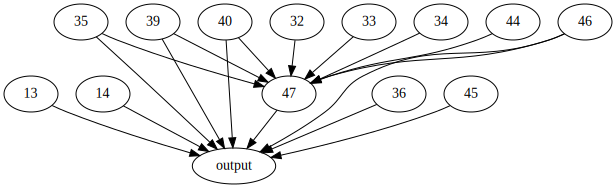

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 1.pkl
patching 80 edges, keeping 17 edges, 1128 remain
patching 80 edges, keeping 17 edges, 1128 remain
baseline score 2.727365016937256
[47] sized edge sets remaining
got scores tensor([2.6500], device='cuda:0')
splitting 47 edges into two edge sets, as they have score 2.6499931812286377 which has diff 0.07737183570861816 > 1e-05
patching 80 edges, keeping 17 edges, 1128 remain
baseline score 2.727365016937256
[23, 24] sized edge sets remaining
got scores tensor([2.7277, 2.6498], device='cuda:0')
splitting 24 edges into two edge sets, as they have score 2.64979887008667 which has diff 0.07756614685058594 > 1e-05
doing rollback test with score 2.727689743041992 and score_lost_by_edge_set -0.0003247261047363281 with edge set of size 23
rolling back with pivot 1
patching 23 edges with score 2.727689743041992 with diff of -0.0003247261047363281
but patching with others at the same time, overall they have score 2.7276430130004883 wit

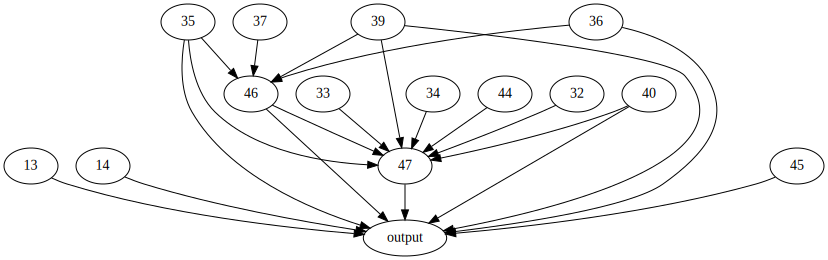

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 2.pkl
patching 123 edges, keeping 21 edges, 1081 remain
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[46] sized edge sets remaining
got scores tensor([2.6950], device='cuda:0')
splitting 46 edges into two edge sets, as they have score 2.695035457611084 which has diff 0.0351567268371582 > 1e-05
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[23, 23] sized edge sets remaining
got scores tensor([2.7299, 2.6955], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 2.7298717498779297 which has diff 0.0003204345703125 > 1e-05
splitting 23 edges into two edge sets, as they have score 2.695518732070923 which has diff 0.034673452377319336 > 1e-05
patching 123 edges, keeping 21 edges, 1081 remain
baseline score 2.730192184448242
[11, 12, 11, 12] sized edge sets remaining
got scores tensor([2.7304, 2.7297, 2.7301, 2.6954], device='cuda:0')
split

  0%|          | 0/3 [00:00<?, ?it/s]

got scores tensor([2.7304, 2.7308, 2.7305, 2.7305, 2.7302, 2.7209, 2.7089, 2.7286],
       device='cuda:0')
splitting 3 edges into two edge sets, as they have score 2.7303872108459473 which has diff 0.00038433074951171875 > 1e-05
splitting 2 edges into two edge sets, as they have score 2.7305409908294678 which has diff 0.00023055076599121094 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7304766178131104 which has diff 0.0002949237823486328 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7302398681640625 which has diff 0.0005316734313964844 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.720851182937622 which has diff 0.009920358657836914 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7088823318481445 which has diff 0.021889209747314453 > 1e-05
splitting 3 edges into two edge sets, as they have score 2.7286040782928467 which has diff 0.0021674633026123047 > 1e-05
doing rollback test with score 2.7308218479156

  0%|          | 0/5 [00:00<?, ?it/s]

got scores tensor([2.7308, 2.7304, 2.7307, 2.7306, 2.7306, 2.7307, 2.7307, 2.7303, 2.7290,
        2.7226, 2.7079, 2.7304, 2.7329, 2.7264], device='cuda:0')
splitting 2 edges into two edge sets, as they have score 2.730363130569458 which has diff 0.00040411949157714844 > 1e-05
keeping edge edge  22 -> 45 (('blocks.22.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7307021617889404 which has diff 6.508827209472656e-05 > 1e-05
keeping edge edge  23 -> 45 (('blocks.23.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7306480407714844 which has diff 0.00011920928955078125 > 1e-05
keeping edge edge  24 -> 45 (('blocks.24.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.

  0%|          | 0/4 [00:00<?, ?it/s]

got scores tensor([2.7326, 2.7329, 2.7329, 2.7329, 2.7334, 2.7319, 2.7319, 2.7258, 2.7323,
        2.7330, 2.7307, 2.7309], device='cuda:0')
keeping edge edge  17 -> 45 (('blocks.17.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.7325551509857178 which has diff 0.0003559589385986328 > 1e-05
keeping edge edge  35 -> 45 (('blocks.35.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.731937885284424 which has diff 0.0009732246398925781 > 1e-05
keeping edge edge  37 -> 45 (('blocks.37.hook_out_proj', <function storage_hook at 0x7fb524c0a440>) -> ('blocks.45.hook_layer_input', <function resid_patching_hook at 0x7fb524c0a680>))) with score 2.731912851333618 which has diff 0.0009982585906982422 > 1e-05
keeping edge edge  38 -> 45 (('blocks.38.hook_out_proj', <function storage_hoo

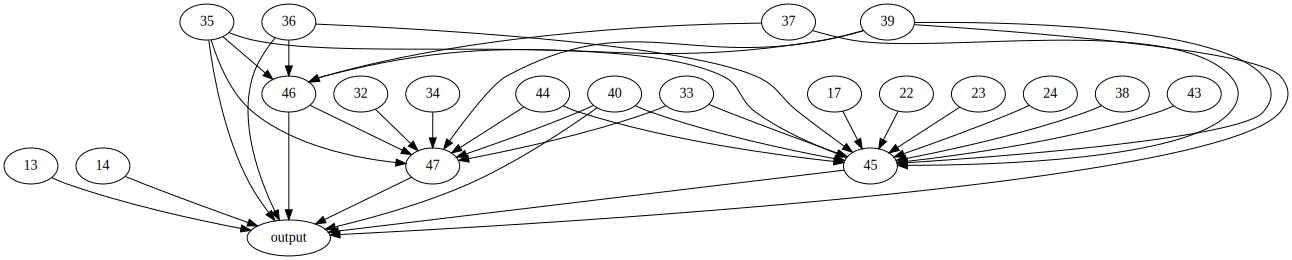

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 3.pkl
patching 156 edges, keeping 34 edges, 1035 remain
patching 156 edges, keeping 34 edges, 1035 remain
baseline score 2.7333104610443115
[45] sized edge sets remaining
got scores tensor([2.7272], device='cuda:0')
splitting 45 edges into two edge sets, as they have score 2.727161407470703 which has diff 0.0061490535736083984 > 1e-05
patching 156 edges, keeping 34 edges, 1035 remain
baseline score 2.7333104610443115
[22, 23] sized edge sets remaining
got scores tensor([2.7337, 2.7268], device='cuda:0')
splitting 23 edges into two edge sets, as they have score 2.72684383392334 which has diff 0.00646662712097168 > 1e-05
doing rollback test with score 2.7336599826812744 and score_lost_by_edge_set -0.0003495216369628906 with edge set of size 22
rolling back with pivot 1
patching 22 edges with score 2.7336599826812744 with diff of -0.0003495216369628906
but patching with others at the same time, overall they have score 2.733613014221

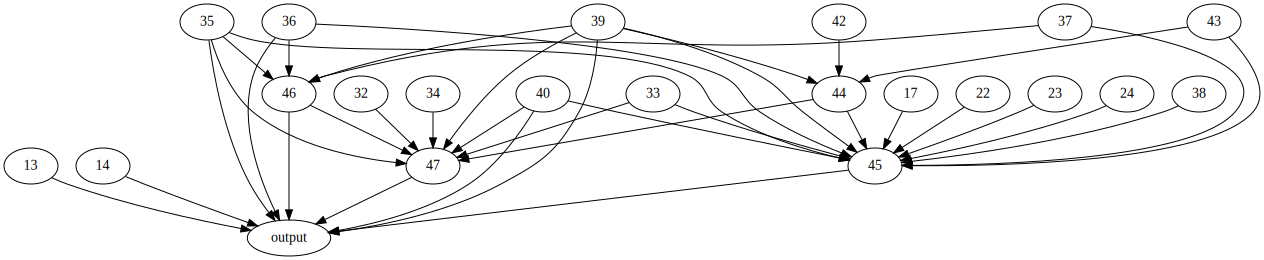

saved to checkpoint ckpts/2024-03-28_17-42-23/checkpoint 4.pkl
patching 198 edges, keeping 37 edges, 990 remain
patching 198 edges, keeping 37 edges, 990 remain
baseline score 2.7411577701568604
[44] sized edge sets remaining
got scores tensor([2.7378], device='cuda:0')
splitting 44 edges into two edge sets, as they have score 2.737790822982788 which has diff 0.0033669471740722656 > 1e-05
patching 198 edges, keeping 37 edges, 990 remain
baseline score 2.7411577701568604
[22, 22] sized edge sets remaining
got scores tensor([2.7414, 2.7376], device='cuda:0')
splitting 22 edges into two edge sets, as they have score 2.737604856491089 which has diff 0.0035529136657714844 > 1e-05
doing rollback test with score 2.741441011428833 and score_lost_by_edge_set -0.00028324127197265625 with edge set of size 22
rolling back with pivot 1
patching 22 edges with score 2.741441011428833 with diff of -0.00028324127197265625
but patching with others at the same time, overall they have score 2.741394042968

In [ ]:
from transformer_lens.hook_points import HookPoint
from acdc import Edge, ACDCConfig, LOG_LEVEL_INFO, LOG_LEVEL_DEBUG, run_acdc

global storage
storage = {}
def storage_hook(
    x,
    hook: HookPoint,
    **kwargs,
):
    global storage
    storage[hook.name] = x
    return x

def resid_patching_hook(
    x,
    hook: HookPoint,
    input_hook_name: str,
    batch_start: int,
    batch_end: int,
):
    global storage
    x_uncorrupted = storage[input_hook_name][batch_start:batch_end:2]
    x_corrupted = storage[input_hook_name][batch_start+1:batch_end:2]
    x[batch_start:batch_end:2] = x[batch_start:batch_end:2] - x_uncorrupted + x_corrupted
    return x

layers = list(range(model.cfg.n_layers))

## Setup edges for ACDC
edges = []

B,L = data.data.size()

INPUT_HOOK = f'hook_embed'
INPUT_NODE = 'input'

last_layer = max(layers)
OUTPUT_HOOK = f'blocks.{last_layer}.hook_resid_post'
OUTPUT_NODE = 'output'

def layer_node(layer):
    return f'{layer}'

# direct connection from embed to output
edges.append(Edge(
        input_node=INPUT_NODE,
        input_hook=(INPUT_HOOK, storage_hook),
        output_node=OUTPUT_NODE,
        output_hook=(OUTPUT_HOOK, resid_patching_hook),
))

for layer in layers:
    # edge from embed to layer input
    edges.append(Edge(
            input_node=INPUT_NODE,
            input_hook=(INPUT_HOOK, storage_hook),
            output_node=layer_node(layer),
            output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
    ))

    # edge from some other earlier layer to this layer
    for other_layer in layers:
        if other_layer < layer:
            edges.append(Edge(
                    input_node=layer_node(other_layer),
                    input_hook=(f'blocks.{other_layer}.hook_out_proj', storage_hook),
                    output_node=layer_node(layer),
                    output_hook=(f'blocks.{layer}.hook_layer_input', resid_patching_hook),
            ))

    # edge from layer output to final layer output
    edges.append(Edge(
            input_node=layer_node(layer),
            input_hook=(f'blocks.{layer}.hook_out_proj', storage_hook),
            output_node=OUTPUT_NODE,
            output_hook=(OUTPUT_HOOK, resid_patching_hook),
    ))

model_kwargs = {
    'fast_ssm': True,
    'fast_conv': True,
}


def normalized_logit_diff_metric(data: ACDCEvalData):
    B,V = data.patched.logits.size()

    # [batch_size]
    patched_correct = data.patched.correct[:,0]
    A_logits_unpatched = data.unpatched.logits[torch.arange(B), patched_correct]
    A_logits_patched = data.patched.logits[torch.arange(B), patched_correct]
    A_logits_corrupted = data.corrupted.logits[torch.arange(B), patched_correct]

    corrupted_correct = data.corrupted.correct[:,0]
    B_logits_unpatched = data.unpatched.logits[torch.arange(B), corrupted_correct]
    B_logits_patched = data.patched.logits[torch.arange(B), corrupted_correct]
    B_logits_corrupted = data.corrupted.logits[torch.arange(B), corrupted_correct]

    # A and B are two potential outputs
    # if A patched > B patched, we are correct
    # else we are incorrect

    # thus we could just return A_logits_patched - B_logits_patched

    # however it is useful to "normalize" these values

    # in the worst case, our patching causes us to act like corrupted, and our diff will be
    # A_logits_corrupted - B_logits_corrupted
    # this will result in a small, negative value
    
    # in the best case, our patching will do nothing (cause us to act like unpatched), and our diff will be
    # A_logits_unpatched - B_logits_unpatched
    # this will result in a large, positive value

    # thus we can treat those as the "min" and "max" and normalize accordingly
    
    min_diff = A_logits_corrupted - B_logits_corrupted
    max_diff = A_logits_unpatched - B_logits_unpatched

    possible_range = (max_diff-min_diff)
    possible_range[possible_range == 0] = 1.0 # prevent divide by zero
    
    diff = A_logits_patched - B_logits_patched
    normalized_diff = (diff-min_diff)/possible_range

    # as described, 1.0 corresponds to acting like unpatched,
    # and 0.0 corresponds to acting like corrupted

    return torch.mean(normalized_diff)
    
    
cfg = ACDCConfig(
    thresh = 0.00001,
    rollback_thresh = 0.00001,
    metric=normalized_logit_diff_metric,
    # extra inference args
    model_kwargs=model_kwargs,
    # these are needed for doing graph pruning
    input_node=INPUT_NODE,
    output_node=OUTPUT_NODE,
    # batch size for evaluating data points
    batch_size=3,
    log_level=LOG_LEVEL_INFO,
    # if False, will be equivalent to batch_size=1
    batched = True,
    # set these two to false to use traditional ACDC
    # recursive will try patching multiple at a time (this is faster sometimes)
    recursive = True,
    # try_patching_multiple_at_same_time will evaluate many different patchings before commiting to any
    # and includes a rollback scheme if after patching one, the others get worse
    try_patching_multiple_at_same_time = True,
    ## if true, you metric will also have the logits from a run with no patching available
    # (useful for normalized logit diff)
    store_unpatched_logits = True,
)

result_edges = run_acdc(model=model, data=data, cfg=cfg, edges=edges)



